# **Imports**


In [1]:
# Custom libraries
from tools.DataLoader import DataLoader
from tools.EDA import EDA
from tools.CNNPreprocessor import CNNPreprocessor
from tools.CNNTrainer import CNNTrainer
from tools.CNNEvaluator import CNNEvaluator


# Custom PyTorch models
from models.PyTorchCNNClassifier import PyTorchCNNClassifier

In [2]:
import torch

print(torch.cuda.is_available())
print(torch.version.cuda)

False
12.1


# **Data Load**


In [3]:
# Step 1: Load Data using DataLoader
train_loader = DataLoader(dataset_type="train", path="./db/seg_train")
train_dataset = train_loader.load_data()

# Initialize the data loader for a test dataset
test_loader = DataLoader(dataset_type="test", path="./db/seg_test")
test_dataset = test_loader.load_data()

# Initialize the data loader for a val dataset
val_loader = DataLoader(dataset_type="val", path="./db/seg_pred")
val_dataset = val_loader.load_unlabeled_data()

In [4]:
print(f"Train dataset type: {type(train_dataset)}")
print(f"Test dataset type: {type(test_dataset)}")
print(f"Val dataset type: {type(val_dataset)}")

Train dataset type: <class 'torchvision.datasets.folder.ImageFolder'>
Test dataset type: <class 'torchvision.datasets.folder.ImageFolder'>
Val dataset type: <class 'list'>


# **EDA**


In [5]:
eda = EDA(train_dataset, train_dataset.classes)

In [6]:
# eda.show_sample_images(num_images=6)

In [7]:
# eda.show_images_from_each_class()

In [8]:
# eda.plot_class_distribution()

In [9]:
# eda.show_image_shape()

# **Preprocessing**


In [10]:
preprocessor = CNNPreprocessor()

In [11]:
preprocessor.help()

Available transformations and their parameters:
+----------------------+----------------------------------------------------------------------+--------------------------------------------------------------------+
| Transformation       | Description                                                          | Parameters                                                         |
+======================+======================================================================+====================================================================+
| RandomResizedCrop    | Randomly crops a part of the image and resizes it to the given size. | size: (int): Target size of the crop.                              |
+----------------------+----------------------------------------------------------------------+--------------------------------------------------------------------+
| RandomHorizontalFlip | Randomly flips the image horizontally with a given probability.      | p: (float): Probability of flip

In [12]:
# Задаем настройки трансформаций для тренировочного, валидационного и тестового наборов данных
preprocessor.set_transform_settings(
    train_transform_settings={
        "RandomResizedCrop": {"enabled": True, "size": 224},
        "RandomHorizontalFlip": {"enabled": True, "p": 0.5},
        "ToTensor": {"enabled": True},
        "Normalize": {
            "enabled": True,
            "mean": [0.485, 0.456, 0.406],
            "std": [0.229, 0.224, 0.225],
        },
    },
    test_transform_settings={
        "Resize": {"enabled": True, "size": 256},
        "CenterCrop": {"enabled": True, "size": 224},
        "ToTensor": {"enabled": True},
        "Normalize": {
            "enabled": True,
            "mean": [0.485, 0.456, 0.406],
            "std": [0.229, 0.224, 0.225],
        },
    },
    val_transform_settings={
        "Normalize": {
            "enabled": True,
            "mean": [0.485, 0.456, 0.406],
            "std": [0.229, 0.224, 0.225],
        },
    },
)

In [13]:
# Проверим первое изображение из набора данных
img_train, label_img_train = train_dataset[0]
img_test, label_test = test_dataset[0]
img_val = val_dataset[0]

print(f"Image type train: {type(img_train)}")
print(f"Image type test: {type(img_test)}")
print(f"Image type val: {type(img_val)}")

Image type train: <class 'torch.Tensor'>
Image type test: <class 'torch.Tensor'>
Image type val: <class 'torch.Tensor'>


In [14]:
# Применение трансформаций к тренировочному датасету
transformed_train_dataset = preprocessor.transform_dataset(
    train_dataset, dataset_type="train"
)

# Применение трансформаций к тестовому датасету
transformed_test_dataset = preprocessor.transform_dataset(
    test_dataset, dataset_type="test"
)

In [15]:
print(f"Train dataset type: {type(transformed_train_dataset)}")
print(f"Test dataset type: {type(transformed_test_dataset)}")

Train dataset type: <class 'torchvision.datasets.folder.ImageFolder'>
Test dataset type: <class 'torchvision.datasets.folder.ImageFolder'>


In [16]:
# Применение трансформаций к валидационному датасету
transformed_val_dataset = preprocessor.transform_unlabeled_data(val_dataset)

In [17]:
print(f"Val dataset type: {type(transformed_val_dataset)}")

Val dataset type: <class 'list'>


In [18]:
# Проверим первое изображение из набора данных
img_train, label_img_train = transformed_train_dataset[0]
img_test, label_test = transformed_test_dataset[0]
img_val = transformed_val_dataset[0]

print(f"Image type train: {type(img_train)}")
print(f"Image type test: {type(img_test)}")
print(f"Image type val: {type(img_val)}")

Image type train: <class 'torch.Tensor'>
Image type test: <class 'torch.Tensor'>
Image type val: <class 'torch.Tensor'>


In [19]:
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 6


In [20]:
model = PyTorchCNNClassifier(
    input_channels=3, num_classes=num_classes, random_state=42, epochs_logger=True
)

In [21]:
# param_grid = {
#     "conv_layers": [
#         [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)]
#     ],  # out_channels, kernel_size, stride, padding
#     "hidden_sizes": [[256, 128]],  # Fully connected layers
#     "lr": [0.001, 0.01],  # Learning rate
#     "batch_size": [16, 32],  # Batch size
#     "epochs": [10, 20],  # Number of epochs
#     "dropout_rate": [0.1, 0.3],  # Dropout rate for fully connected layers
#     "optimizer_type": ["sgd", "adam"],  # Optimizer type
#     "activation_fn": ["ReLU", "Sigmoid"],  # Activation function choices as strings
#     "pool_fn": ["MaxPool2d", "AvgPool2d"],  # Pooling function choices as strings
#     "pool_kernel_size": [2, 3],  # Pooling kernel size
#     "pool_stride": [2, 1],  # Pooling stride
#     "pool_padding": [0, 1],  # Pooling padding
# }

param_grid = {
    "conv_layers": [[(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)]],
    "hidden_sizes": [[256, 128]],
    "lr": [0.001],
    "batch_size": [16],
    "epochs": [10],
    "dropout_rate": [0.1],
    "optimizer_type": ["adam"],
    "activation_fn": ["ReLU"],
    "pool_fn": ["MaxPool2d"],
    "pool_kernel_size": [2],
    "pool_stride": [2],
    "pool_padding": [0],
}

In [22]:
models = {"cnn_model": model}
param_grids = {"cnn_model": param_grid}

# **Model Training**


In [23]:
model_trainer = CNNTrainer(device="cuda")

In [24]:
model_trainer.help()

=== CNNTrainer Help ===
This trainer is designed to support classification tasks using PyTorch CNN models.

Usage:
1. Initialize the CNNTrainer with the device ('cpu' or 'cuda').
   Example:
       trainer = CNNTrainer(device='cuda')

2. Create model objects and define the parameter grid for hyperparameter tuning.
   Example:
       param_grid = { "lr": [0.001, 0.01], "epochs": [10, 20] }

3. Call the `train` method with the training and test datasets, models, and parameter grid.
   Example:
       trainer.train(train_dataset, test_dataset, models={'cnn_model': model}, param_grids={'cnn_model': param_grid})


In [25]:
model_trainer.train(
    train_dataset=transformed_train_dataset,
    test_dataset=transformed_test_dataset,
    models=models,
    param_grids=param_grids,
    scoring="accuracy",
    verbose=1,
    use_progress_bar=True,
)

Training on device: cuda

Training cnn_model with parameters: {'activation_fn': 'ReLU', 'batch_size': 16, 'conv_layers': [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)], 'dropout_rate': 0.1, 'epochs': 10, 'hidden_sizes': [256, 128], 'lr': 0.001, 'optimizer_type': 'adam', 'pool_fn': 'MaxPool2d', 'pool_kernel_size': 2, 'pool_padding': 0, 'pool_stride': 2}


Training cnn_model:   0%|          | 0/10 [00:00<?, ?it/s]

Training with parameters: {'activation_fn': 'ReLU', 'batch_size': 16, 'conv_layers': [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)], 'dropout_rate': 0.1, 'epochs': 10, 'hidden_sizes': [256, 128], 'lr': 0.001, 'optimizer_type': 'adam', 'pool_fn': 'MaxPool2d', 'pool_kernel_size': 2, 'pool_padding': 0, 'pool_stride': 2}


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [84]:
best_models = model_trainer.best_estimators
best_params = model_trainer.best_params
best_scores = model_trainer.best_scores
best_model_name = model_trainer.best_model_name

In [85]:
print(best_models)
print(best_params)
print(best_scores)
print(best_model_name)

# **Model Evaluator**


In [86]:
evaluator = CNNEvaluator()

In [87]:
evaluator.visualize_pipeline(model_name=best_model_name, best_models=best_models)

Visualizing the architecture of the model: pytorch_regressor
Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            2,560
├─ReLU: 1-2                              --
├─Dropout: 1-3                           --
├─Linear: 1-4                            32,896
├─Tanh: 1-5                              --
├─Dropout: 1-6                           --
├─Linear: 1-7                            8,256
├─ReLU: 1-8                              --
├─Dropout: 1-9                           --
├─Linear: 1-10                           65
Total params: 43,777
Trainable params: 43,777
Non-trainable params: 0


In [88]:
evaluator.display_results(
    test_dataset=transformed_test_dataset,
    best_models=best_models,
    best_params=best_params,
    best_scores=best_scores,
    best_model_name=best_model_name,
    help_text=True,
)

Extracted PyTorch model: Sequential(
  (0): Linear(in_features=9, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=64, out_features=1, bias=True)
)
Model is on device: cpu
Evaluation Metrics for Validation Set:


,Model,R²,MAE,MAPE,MSE
0,pytorch_regressor,0.871213,4.531914,0.146756,33.185549



Best Parameters for Each Model (found during cross-validation):


,Model,regressor__batch_size,regressor__criterion_type,regressor__dropout_rate,regressor__epochs,regressor__hidden_sizes,regressor__lr,regressor__optimizer_type
0,pytorch_regressor,16,mse,0.1,200,"[256, 128, 64]",0.01,sgd



Overall Best Model and Score (based on cross-validation score):


,Overall Best Model,Score (based on cross-validation score)
0,pytorch_regressor,35.730794



Metric Explanations for Regression:
R²: Proportion of the variance explained by the model (higher is better).
MAE: Mean Absolute Error, average error magnitude (lower is better).
MAPE: Mean Absolute Percentage Error (lower is better).
MSE: Mean Squared Error (lower is better).


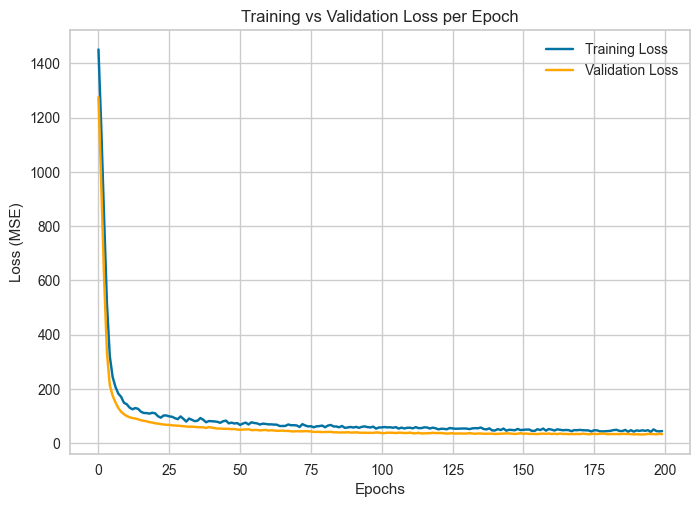

In [89]:
evaluator.plot_loss_history(best_models, best_model_name)

In [90]:
evaluator.validate_on_test(
    val_dataset=transformed_val_dataset,
    best_models=best_models,
    best_model_name=best_model_name,
    task_type="regression",
)

Results for the model on the test set:


,R²,MAE,MAPE,MSE
Model Evaluation,0.871213,4.531914,0.146756,33.185549


# **Key Conclusions and Recommendations for Improvement**


# **Key Conclusions:**

**High Model Accuracy:** The model achieved R² = 0.8808, meaning it explains 88.08% of the variance in the target variable, indicating strong predictive performance.

**Low Error:** Metrics MAE = 4.36, MAPE = 14.21%, and MSE = 30.73 (the primary metric used during training) indicate a relatively low average error, with predictions deviating by about 14% from actual values.

**Optimal Hyperparameters:** I tested architectures with both 3 layers [256, 128, 64] and 5 layers [256, 128, 64, 32, 16], with the 3-layer configuration performing better. Various hyperparameters were explored, including batch sizes (16, 32), learning rates (0.01, 0.001), dropout rates (0.1, 0.2, 0.3), and both the Adam and SGD optimizers, with SGD yielding the best results.

# **Model Architecture:**

**Hidden Layers:** The architecture consists of fully connected layers. The best-performing model used 3 hidden layers with 256, 128, and 64 neurons, alternating between ReLU and Tanh activations.

**Regularization:** Dropout layers with varying rates (0.1, 0.2, 0.3) were included after each hidden layer to prevent overfitting, with a 0.1 dropout rate proving optimal. This acts as a form of early stopping by reducing overfitting as the model trains.
Optimizer and Loss Function: The SGD optimizer combined with the mean squared error (MSE) loss function was used for training.

# **Recommendations:**

**Explore Deeper Architectures:** Although the 3-layer model performed better, further tuning of deeper architectures (5+ layers) with additional regularization techniques could be beneficial.

**Refine Dropout and Learning Rate:** Fine-tuning the dropout rates and using learning rate schedules could improve convergence and prevent overfitting. Dropout, already implemented in the model, acts as an early stopping mechanism by preventing overfitting during training.
Early Stopping and Optimization: Besides dropout, consider experimenting with more advanced early stopping strategies, combined with fine-tuning the learning rates for further optimization.
